https://medium.com/@srijith.rajamohan/using-bayesian-hierarchical-models-in-pymc3-to-infer-the-disease-parameters-of-covid-19-b396c8b9845
https://databricks.com/blog/2021/01/06/bayesian-modeling-of-the-temporal-dynamics-of-covid-19-using-pymc3.html
https://sjster.github.io/introduction_to_computational_statistics/docs/Production/Covid_modeling.html


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff
import scipy.stats
import pymc3 as pm
import arviz as az
import sunode
import sunode.wrappers.as_theano
from pymc3.ode import DifferentialEquation
import theano.tensor as tt
import datetime
import shelve
from datetime import datetime as dt
import time
import warnings
warnings.filterwarnings('ignore')

Poosible replacement if I prefer to use data from Brazilian cities on the hierarchical model

In [2]:
from graphviz import Digraph
# Create Digraph object
dot = Digraph()

In [3]:
#pd.read_csv("https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv", date_parser=True).dtypes

In [3]:
class COVID_data():
     
    def __init__(self, country='Brazil', Population = 212.6e6):
 
        confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
        self.confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
        deaths_url =  'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
        self.deaths = pd.read_csv(deaths_url, sep=',')
        self.country = country
        self.N = Population   # Population of the country - you need to define the s0 at t0 on ode IVP problemns
 
    def get_dates(self, data_begin='7/11/20', data_end='7/20/20'):
 
        # ------------------------- Date for inference ----------------------#
        self.data_begin = data_begin 
        self.data_end = data_end
        confirmed_cases = self.confirmed_cases
        country = self.country
        self.cases_obs = np.array(confirmed_cases.loc[confirmed_cases["Country/Region"] == country, data_begin:data_end])[0]
 
        print(f"------------ COVID Data for {country}, from {data_begin} to {data_end}, Loaded ----------- ")

1. Modularizar ao máximo o código
    - Inclusive separando a o model do run caso seja possível vizualizar o diagrama do modelo -> TENTAR
2. Montar código básico para modelo hierarquico (aka incluindo +1 país)
    - Refletir se quero isto direto ou já crio notebook com dados sintéticos
3. Criar ambiente funcional de MLFlow

In [4]:
class SIR_model_sunode():
 
    def __init__(self, covid_data) :
 
        # ------------------------- Covid_data object -----------------------#
        self.covid_data = covid_data
        # ------------------------- Setup SIR model, but has to be called explicitly to run ------------------------#
        self.setup_SIR_model()
 
    def SIR_sunode_rhs_ode(self, t, y, p):
        return {
            'S': -p.lam * y.S * y.I,
            'I': p.lam * y.S * y.I - p.mu * y.I,
        }
 
    def setup_SIR_model(self):
        self.time_range = np.arange(0,len(self.covid_data.cases_obs),1)
        self.I0 = self.covid_data.cases_obs[0]
        self.S0 = self.covid_data.N - self.I0
        self.S_init = self.S0 / self.covid_data.N
        self.I_init = self.I0 / self.covid_data.N
        self.cases_obs_scaled = self.covid_data.cases_obs / self.covid_data.N
 
 
    def run_SIR_model(self, n_samples, n_tune, likelihood, prior):
        # ------------------------- Metadata --------------------------------#
        self.likelihood = likelihood
        self.n_samples = n_samples
        self.n_tune = n_tune
        self.likelihood = likelihood
        self.prior = prior
        
        ## posteroily, I'll add those on MLFlow XP
        #t = time.time()
 
        with pm.Model() as model4:
            ## pymc RVs - Priors
            sigma = pm.HalfCauchy('sigma', self.likelihood['sigma'], shape=1)
            lam = pm.Lognormal('lambda', self.prior['lam'], self.prior['lambda_std']) # 1.5, 1.5
            mu = pm.Lognormal('mu', self.prior['mu'], self.prior['mu_std'])           # 1.5, 1.5
            ## sunode ODE equation and gradients computed using sunode
            res, _, problem, solver, _, _ = sunode.wrappers.as_theano.solve_ivp(
                y0={'S': (self.S_init, ()), 'I': (self.I_init, ()),},
                params={'lam': (lam, ()), 'mu': (mu, ()), '_dummy': (np.array(1.), ())},
                rhs=self.SIR_sunode_rhs_ode,
                tvals=self.time_range,
                t0=self.time_range[0]
            )
            ## pymc RVs - likelihood
            if(likelihood['distribution'] == 'lognormal'):
                I = pm.Lognormal('I', mu=res['I'], sigma=sigma, observed=self.cases_obs_scaled)
            elif(likelihood['distribution'] == 'normal'):
                I = pm.Normal('I', mu=res['I'], sigma=sigma, observed=self.cases_obs_scaled)
            elif(likelihood['distribution'] == 'students-t'):
                I = pm.StudentT( "I",  nu=likelihood['nu'],       # likelihood distribution of the data
                        mu=res['I'],     # likelihood distribution mean, these are the predictions from SIR
                        sigma=sigma,
                        observed=self.cases_obs_scaled
                        )
            R0 = pm.Deterministic('R0',lam/mu)
            
            ## pymc posteriori sampling
            trace = pm.sample(self.n_samples, tune=self.n_tune, 
                              chains=4, cores=4) #mp_ctx="forkserver", pickle_backend='dill' - opt args
            
            data = az.from_pymc3(trace=trace)
 
        #t1 = time.time() - t
        ## viz
        az.plot_posterior(data, round_to=2, point_estimate='mode', hdi_prob=0.95)
        axes = az.plot_trace(trace)
        fig = axes.ravel()[0].figure
        #fig.savefig(self.filename)
        
        fig = ff.create_distplot([trace['R0']], bin_size=0.5, group_labels=['x'])
 
        # Add title
        fig.update_layout(title_text='Curve and Rug Plot')
        fig.update_xaxes(range=[0,7])
              
        ## posteroily, I'll add those on MLFlow XP
        #self.metadata_db = shelve.open(metadata_db_filename)
        #self.metadata_db[self.filename] = {'type': 'sir', 'samples': n_samples,
        #                            'tune': n_tune,
        #                            'elapsed_time': t1,
        #                            'finished': dt.now().strftime("%d-%m-%Y_%H:%M:%S"),
        #                            'likelihood': likelihood,
        #                            'prior': prior }
        #self.metadata_db.close()
        return(fig)
 
 
 

In [9]:
class SIR_model_sunode():
 
    def __init__(self, covid_data) :
        # ------------------------- Covid_data object -----------------------#
        self.covid_data = covid_data
        # ------------------------- Setup SIR model, but has to be called explicitly to run ------------------------#
        self._setup_SIR_model_data()
 

    def _setup_SIR_model_data(self):
        
        self.time_range = np.arange(0,len(self.covid_data.cases_obs),1)
        self.I0 = self.covid_data.cases_obs[0]
        self.S0 = self.covid_data.N - self.I0
        self.S_init = self.S0 / self.covid_data.N
        self.I_init = self.I0 / self.covid_data.N
        self.cases_obs_scaled = self.covid_data.cases_obs / self.covid_data.N
 

    def SIR_sunode_rhs_ode(self, t, y, p):
        
        rhs_ode_dict = {
            'S': -p.lam * y.S * y.I,
            'I': p.lam * y.S * y.I - p.mu * y.I,
        }
        
        return rhs_ode_dict
    
    
    def build_pymc_SIR_model(self, likelihood, prior):
        # ------------------------- Metadata --------------------------------#
        self.likelihood = likelihood
        self.prior = prior
 
        with pm.Model() as model:
            ## pymc RVs - Priors
            sigma = pm.HalfCauchy('sigma', self.likelihood['sigma'], shape=1)
            lam = pm.Lognormal('lambda', self.prior['lam'], self.prior['lambda_std']) # 1.5, 1.5
            mu = pm.Lognormal('mu', self.prior['mu'], self.prior['mu_std'])           # 1.5, 1.5
            ## sunode ODE equation and gradients computed using sunode
            res, _, problem, solver, _, _ = sunode.wrappers.as_theano.solve_ivp(
                y0={'S': (self.S_init, ()), 'I': (self.I_init, ()),},
                params={'lam': (lam, ()), 'mu': (mu, ()), '_dummy': (np.array(1.), ())},
                rhs=self.SIR_sunode_rhs_ode,
                tvals=self.time_range,
                t0=self.time_range[0]
            )
            ## pymc RVs - likelihood
            if(likelihood['distribution'] == 'lognormal'):
                I = pm.Lognormal('I', mu=res['I'], sigma=sigma, observed=self.cases_obs_scaled)
            elif(likelihood['distribution'] == 'normal'):
                I = pm.Normal('I', mu=res['I'], sigma=sigma, observed=self.cases_obs_scaled)
            elif(likelihood['distribution'] == 'students-t'):
                I = pm.StudentT( "I",  nu=likelihood['nu'],       # likelihood distribution of the data
                        mu=res['I'],     # likelihood distribution mean, these are the predictions from SIR
                        sigma=sigma,
                        observed=self.cases_obs_scaled
                        )
            R0 = pm.Deterministic('R0',lam/mu)
        
        self.pymc_model = model
        
        
    def plot_pymc_SIR_model_dag(self):
        
        dag_fig = pm.model_to_graphviz(self.pymc_model)
        return dag_fig
        #pm.model_to_graphviz(self.pymc_model)
    
    def sample_pymc_SIR_model(self, n_samples, n_tune, n_chains, n_cores):
        
        self.n_samples = n_samples
        self.n_tune = n_tune
        self.n_chains = n_chains
        self.n_cores = n_cores
        
        try:
            self.pymc_model is not None
        except NotImplementedError as error:
            print('pymc3 model instance not found')

        with self.pymc_model:
            
            trace = pm.sample(self.n_samples, tune=self.n_tune, 
                              chains=self.n_chains, cores=self.n_cores)
        self.pymc_model_trace = trace
        
    
        #    ## pymc posteriori sampling
        #     #mp_ctx="forkserver", pickle_backend='dill' - opt args
        #    
        #    data = az.from_pymc3(trace=trace)
 
        #az.plot_posterior(data, round_to=2, point_estimate='mode', hdi_prob=0.95)
        #axes = az.plot_trace(trace)
        #fig = axes.ravel()[0].figure
        #
        #fig = ff.create_distplot([trace['R0']], bin_size=0.5, group_labels=['x'])
 
        ## Add title
        #fig.update_layout(title_text='Curve and Rug Plot')
        #fig.update_xaxes(range=[0,7])
        #return(fig)

In [10]:
# -------- COVID Data --------#
covid_obj = COVID_data()
covid_obj.get_dates(data_begin='3/1/20', data_end='9/28/20')
# -------- SIR Params --------#
likelihood = {'distribution': 'lognormal', 
              'sigma': 2}
prior = {'lam': 1.0, 
         'mu': 0.5, 
         'lambda_std': 1.0,
         'mu_std': 0.2 }
# -------- SIR Obj Loading --------#
sir_model = SIR_model_sunode(covid_obj)
sir_model.build_pymc_SIR_model(likelihood=likelihood, prior=prior)

------------ COVID Data for Brazil, from 3/1/20 to 9/28/20, Loaded ----------- 


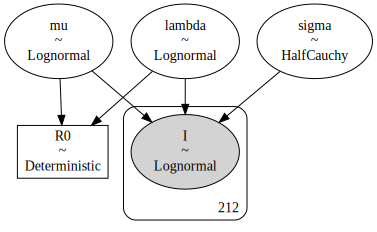

In [11]:
sir_model.plot_pymc_SIR_model_dag()

In [22]:
sir_model.sample_pymc_SIR_model(n_samples=2000, n_tune=1000, n_chains=4, n_cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, sigma]



[CVODES ERROR]  CVode
  At t = 0.116672, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.072162, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.224683, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0446877, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0871924, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.108326, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.226218, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.23532, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.216403, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.212982, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.188136, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.145108, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.263515, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0350682, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.296075, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0447297, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.269413, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0473317, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.0992682, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0906823, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0360849, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.112214, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.160489, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.194892, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.124216, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00677534, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.150698, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.11907, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0641536, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.062392, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.17479, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.156804, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.152531, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.108213, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.119109, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.352014, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.229069, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.3047, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0033682, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.232871, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.225017, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.164627, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.202224, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0149533, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.190111, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0143222, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.199523, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0198042, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.218713, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.263278, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.195814, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.228118, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.174749, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.136641, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.265026, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0465816, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.256056, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0437946, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.260722, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0471967, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.269025, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0308346, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.262935, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0308678, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.242983, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0225525, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO

ValueError: Not enough samples to build a trace.